# Interactive Facial Pose Analysis Pipeline

This notebook demonstrates a comprehensive facial pose analysis pipeline including:
- Data loading and keypoint filtering
- Signal processing (masking, interpolation, filtering)
- Template generation and Procrustes analysis
- Feature extraction and linear metrics
- Interactive visualizations and statistical analysis

**Requirements:** OpenPose CSV files with format `<participantID>_<condition>.csv`


In [24]:
%pip install -q matplotlib numpy pandas scipy tqdm seaborn ipywidgets
%matplotlib inline

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys

# Make sure the pipeline file is on the path
sys.path.append(".")

from pose_pipeline import (
    run_pipeline, Config,
    # We import flags by name so we can set them on the module if needed
)

# ---- Set your data locations here ----
CFG = Config()
CFG.RAW_DIR  = "data/raw/experimental"          # << update if needed
CFG.OUT_BASE = "data/processed/experimental"    # << update if needed

print("Config:")
print(" RAW_DIR :", CFG.RAW_DIR)
print(" OUT_BASE:", CFG.OUT_BASE)



Note: you may need to restart the kernel to use updated packages.
Config:
 RAW_DIR : data/raw/experimental
 OUT_BASE: data/processed/experimental


## 1. Data Loading

Load raw OpenPose CSV files and filter to relevant facial landmarks.

In [25]:
def outputs_exist(base: str | Path) -> dict:
    base = Path(base)
    per_frame = {
        "procrustes_global": list((base / "features" / "per_frame" / "procrustes_global").glob("*.csv")),
        "procrustes_participant": list((base / "features" / "per_frame" / "procrustes_participant").glob("*.csv")),
        "original": list((base / "features" / "per_frame" / "original").glob("*.csv")),
    }
    linear = {
        "procrustes_global": (base / "linear_metrics" / "procrustes_global_linear.csv").exists(),
        "procrustes_participant": (base / "linear_metrics" / "procrustes_participant_linear.csv").exists(),
        "original": (base / "linear_metrics" / "original_linear.csv").exists(),
    }
    any_per_frame = any(len(v) > 0 for v in per_frame.values())
    any_linear = any(linear.values())
    return {
        "per_frame": per_frame,
        "linear": linear,
        "any_per_frame": any_per_frame,
        "any_linear": any_linear,
    }

status = outputs_exist(CFG.OUT_BASE)
print("Found per-frame files:")
for k, v in status["per_frame"].items():
    print(f"  {k:>22}: {len(v)} file(s)")
print("Found linear files:")
for k, v in status["linear"].items():
    print(f"  {k:>22}: {v}")


Found per-frame files:
       procrustes_global: 216 file(s)
  procrustes_participant: 216 file(s)
                original: 216 file(s)
Found linear files:
       procrustes_global: True
  procrustes_participant: True
                original: True


In [27]:
# ---- Select mode based on what's already on disk ----
# You can override these booleans manually if you want.

# Default: assume we'll run full pipeline
RUN_FILTER = True
RUN_MASK = True
RUN_INTERP_FILTER = True
RUN_NORM = True
RUN_TEMPLATES = True
RUN_FEATURES_PROCRUSTES_GLOBAL = True
RUN_FEATURES_PROCRUSTES_PARTICIPANT = True
RUN_FEATURES_ORIGINAL = True
RUN_LINEAR = True

# If we already have per-frame feature CSVs, skip steps 1–7 and do linear-only
if status["any_per_frame"]:
    RUN_FILTER = RUN_MASK = RUN_INTERP_FILTER = RUN_NORM = False
    RUN_TEMPLATES = RUN_FEATURES_PROCRUSTES_GLOBAL = False
    RUN_FEATURES_PROCRUSTES_PARTICIPANT = False
    RUN_FEATURES_ORIGINAL = False
    RUN_LINEAR = True
    print("\nMode: Reuse per-frame features → compute linear metrics only.")
else:
    print("\nMode: Full run (steps 1–7) + linear metrics (step 8).")

# (Optional) If linear files are already present and you do NOT want to overwrite them:
OVERWRITE = True  # set False to keep existing CSVs
OVERWRITE_TEMPLATES = False

# ---- Push flags into the pipeline module's globals so run_pipeline uses them ----
import pose_pipeline as pp

pp.CFG = CFG  # ensure our updated paths are used

pp.RUN_FILTER = RUN_FILTER
pp.RUN_MASK = RUN_MASK
pp.RUN_INTERP_FILTER = RUN_INTERP_FILTER
pp.RUN_NORM = RUN_NORM
pp.RUN_TEMPLATES = RUN_TEMPLATES
pp.RUN_FEATURES_PROCRUSTES_GLOBAL = RUN_FEATURES_PROCRUSTES_GLOBAL
pp.RUN_FEATURES_PROCRUSTES_PARTICIPANT = RUN_FEATURES_PROCRUSTES_PARTICIPANT
pp.RUN_FEATURES_ORIGINAL = RUN_FEATURES_ORIGINAL
pp.RUN_LINEAR = RUN_LINEAR

pp.OVERWRITE = OVERWRITE
pp.OVERWRITE_TEMPLATES = OVERWRITE_TEMPLATES

# ---- Execute ----
pp.run_pipeline()



Mode: Reuse per-frame features → compute linear metrics only.

=== Linear-only mode: reading per-frame CSVs from disk ===


Linear (procrustes_global): 100%|██████████| 216/216 [00:04<00:00, 43.88file/s]


[OK] Wrote data/processed/experimental/linear_metrics/procrustes_global_linear.csv


Linear (procrustes_participant): 100%|██████████| 216/216 [00:04<00:00, 43.63file/s]


[OK] Wrote data/processed/experimental/linear_metrics/procrustes_participant_linear.csv


Linear (original): 100%|██████████| 216/216 [00:03<00:00, 61.29file/s]

[OK] Wrote data/processed/experimental/linear_metrics/original_linear.csv

Summary written to: data/processed/experimental/pipeline_summary.json
Done.


## 2. Feature Extraction with Procrustes Analysis (Global Template)

Extract facial pose features using Procrustes alignment to global template with interactive animation.

In [ ]:
%pip install -q ipympl
%matplotlib widget
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Optional, Dict, Tuple
import os
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import textwrap
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

def create_interactive_pose_timeseries_viewer(
    df_raw: pd.DataFrame,
    df_features: pd.DataFrame, 
    features_to_plot: List[str] = ['blink_dist', 'mouth_dist'],
    landmark_subset: Optional[List[int]] = None,
    figsize: tuple = (16, 10),
    fps: Optional[int] = None,   # computed if None
    pose_sampling_hz: int = 60,
    plot_downsample: int = 2,
    window_seconds: int = 240
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.widgets import Slider, Button
    from matplotlib.patches import Patch

    # ---- config ----
    WINDOW_FRAMES = int(window_seconds * pose_sampling_hz)
    HALF_WIN = WINDOW_FRAMES // 2
    STEP_FRAMES = max(1, plot_downsample)
    if fps is None:
        fps = max(1, pose_sampling_hz // plot_downsample)
    interval_ms = int(1000 / fps)

    # ---- landmarks ----
    if landmark_subset is None:
        landmark_subset = list(range(1, 69))  # 1..68 inclusive
    available_landmarks = [lm for lm in landmark_subset
                           if f'x{lm}' in df_raw.columns and f'y{lm}' in df_raw.columns]
    print(f"Displaying {len(available_landmarks)} landmarks")

    # ---- figure & axes ----
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(len(features_to_plot), 2, width_ratios=[1, 1.5],
                          height_ratios=[1] * len(features_to_plot),
                          hspace=0.3, wspace=0.3)
    ax_pose = fig.add_subplot(gs[:, 0])
    ax_timeseries = []
    for i in range(len(features_to_plot)):
        ax = fig.add_subplot(gs[i, 1]) if i == 0 else fig.add_subplot(gs[i, 1], sharex=ax_timeseries[0])
        ax_timeseries.append(ax)

    # ---- widgets ----
    ax_slider = plt.axes([0.1, 0.02, 0.65, 0.03])
    ax_play   = plt.axes([0.81, 0.02, 0.08, 0.04])

    n_frames = len(df_raw)
    slider = Slider(ax_slider, 'Frame', 0, n_frames - 1, valinit=0, valfmt='%d')
    play_button = Button(ax_play, 'Play')

    state = {'playing': False, 'current_frame': 0}

    # ---- helpers ----
    def get_face_bounds(xs, ys):
        valid_x = xs[~np.isnan(xs)]
        valid_y = ys[~np.isnan(ys)]
        if len(valid_x) == 0:
            return -1, 1, -1, 1
        x_center, y_center = np.mean(valid_x), np.mean(valid_y)
        rng = max(np.ptp(valid_x), np.ptp(valid_y))
        pad = rng * 0.2
        return (x_center - rng/2 - pad, x_center + rng/2 + pad,
                y_center - rng/2 - pad, y_center + rng/2 + pad)

    def update_pose(frame_idx):
        ax_pose.clear()
        x_coords, y_coords, colors = [], [], []
        for lm in available_landmarks:
            x_coords.append(df_raw.loc[frame_idx, f'x{lm}'])
            y_coords.append(df_raw.loc[frame_idx, f'y{lm}'])
            colors.append('blue' if 37 <= lm <= 48 else
                          'red'  if 49 <= lm <= 68 else
                          'green' if 28 <= lm <= 36 else 'gray')
        x_coords = np.array(x_coords); y_coords = np.array(y_coords)
        mask = ~np.isnan(x_coords) & ~np.isnan(y_coords)
        ax_pose.scatter(x_coords[mask], y_coords[mask], c=np.array(colors)[mask], s=20, alpha=0.8)

        def draw(seq, c):
            pts = []
            for lm in seq:
                if lm in available_landmarks:
                    i = available_landmarks.index(lm)
                    if mask[i]:
                        pts.append([x_coords[i], y_coords[i]])
            if len(pts) > 1:
                pts = np.array(pts)
                ax_pose.plot(pts[:, 0], pts[:, 1], color=c, alpha=0.6, linewidth=1.5)

        draw([37,38,39,40,41,42,37], 'blue')
        draw([43,44,45,46,47,48,43], 'blue')
        draw([49,50,51,52,53,54,55,56,57,58,59,60,49], 'red')
        draw([28,29,30,31,32,33,34,35,36], 'green')

        x_min, x_max, y_min, y_max = get_face_bounds(x_coords, y_coords)
        ax_pose.set_xlim(x_min, x_max); ax_pose.set_ylim(y_max, y_min)  # flip Y
        ax_pose.set_aspect('equal'); ax_pose.set_title(f'Facial Pose - Frame {frame_idx}', fontweight='bold')
        ax_pose.grid(True, alpha=0.3)
        ax_pose.legend(handles=[Patch(facecolor='blue', label='Eyes'),
                                Patch(facecolor='red', label='Mouth'),
                                Patch(facecolor='green', label='Nose'),
                                Patch(facecolor='gray', label='Face')],
                       loc='upper right', fontsize=8)

    def update_timeseries(frame_idx):
        start_idx = max(0, frame_idx - HALF_WIN)
        end_idx   = min(len(df_features), frame_idx + HALF_WIN)
        idx = np.arange(start_idx, end_idx)
        idx_ds = idx[::plot_downsample]
        for i, feature in enumerate(features_to_plot):
            ax = ax_timeseries[i]; ax.clear()
            if feature in df_features.columns:
                y = df_features[feature].values
                ax.plot(idx_ds, y[start_idx:end_idx:plot_downsample], '-', alpha=0.8, linewidth=1)
                ax.axvline(frame_idx, linestyle='--', linewidth=2, alpha=0.9)
                if frame_idx < len(df_features):
                    val = y[frame_idx]
                    if not np.isnan(val):
                        ax.scatter(frame_idx, val, s=80, zorder=5)
                        ax.text(frame_idx, val, f'{val:.3f}', ha='center', va='bottom',
                                fontweight='bold',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
                ax.set_xlim(start_idx, end_idx)
                ax.set_ylabel(feature, fontweight='bold'); ax.grid(True, alpha=0.3)
                if i == len(features_to_plot) - 1: ax.set_xlabel('Frame Number', fontweight='bold')
            else:
                ax.text(0.5, 0.5, f'Feature "{feature}" not found', transform=ax.transAxes, ha='center', va='center')

    def update_all(frame_idx, *, from_slider=False):
        frame_idx = int(np.clip(frame_idx, 0, n_frames - 1))
        update_pose(frame_idx)
        update_timeseries(frame_idx)
        state['current_frame'] = frame_idx
        # programmatic slider update without firing callback
        if not from_slider and slider.val != frame_idx:
            slider.eventson = False
            slider.set_val(frame_idx)
            slider.eventson = True
        fig.canvas.draw_idle()

    # ---- callbacks ----
    def on_slider_change(val):
        if not state['playing']:
            update_all(int(val), from_slider=True)

    def toggle_animation(event):
        state['playing'] = not state['playing']
        play_button.label.set_text('Pause' if state['playing'] else 'Play')
        if state['playing']:
            fig._timer.start()
        else:
            fig._timer.stop()

    def step_timer():
        if not state['playing']:
            return
        next_frame = (state['current_frame'] + STEP_FRAMES) % n_frames
        update_all(next_frame, from_slider=False)

    # ---- initial draw BEFORE connecting slider (avoid initial recursion) ----
    update_all(0, from_slider=True)

    # ---- wire callbacks (and keep hard refs) ----
    slider.on_changed(on_slider_change)
    play_button.on_clicked(toggle_animation)
    timer = fig.canvas.new_timer(interval=interval_ms)
    timer.add_callback(step_timer)

    # keep references so widgets/timer don't get GC'd
    fig._widgets = {'slider': slider, 'play_button': play_button}
    fig._timer = timer

    fig.text(0.02, 0.98,
             f'Instructions:\n• Plot decimation ×{plot_downsample}\n'
             f'• Showing {window_seconds}s window (~{WINDOW_FRAMES} frames @ {pose_sampling_hz} Hz)\n'
             f'• Slider = full-res; Play = +{STEP_FRAMES} frame(s)/tick @ ~{fps} Hz',
             transform=fig.transFigure, va='top', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

    plt.show()
    return fig


Note: you may need to restart the kernel to use updated packages.


Displaying 68 landmarks


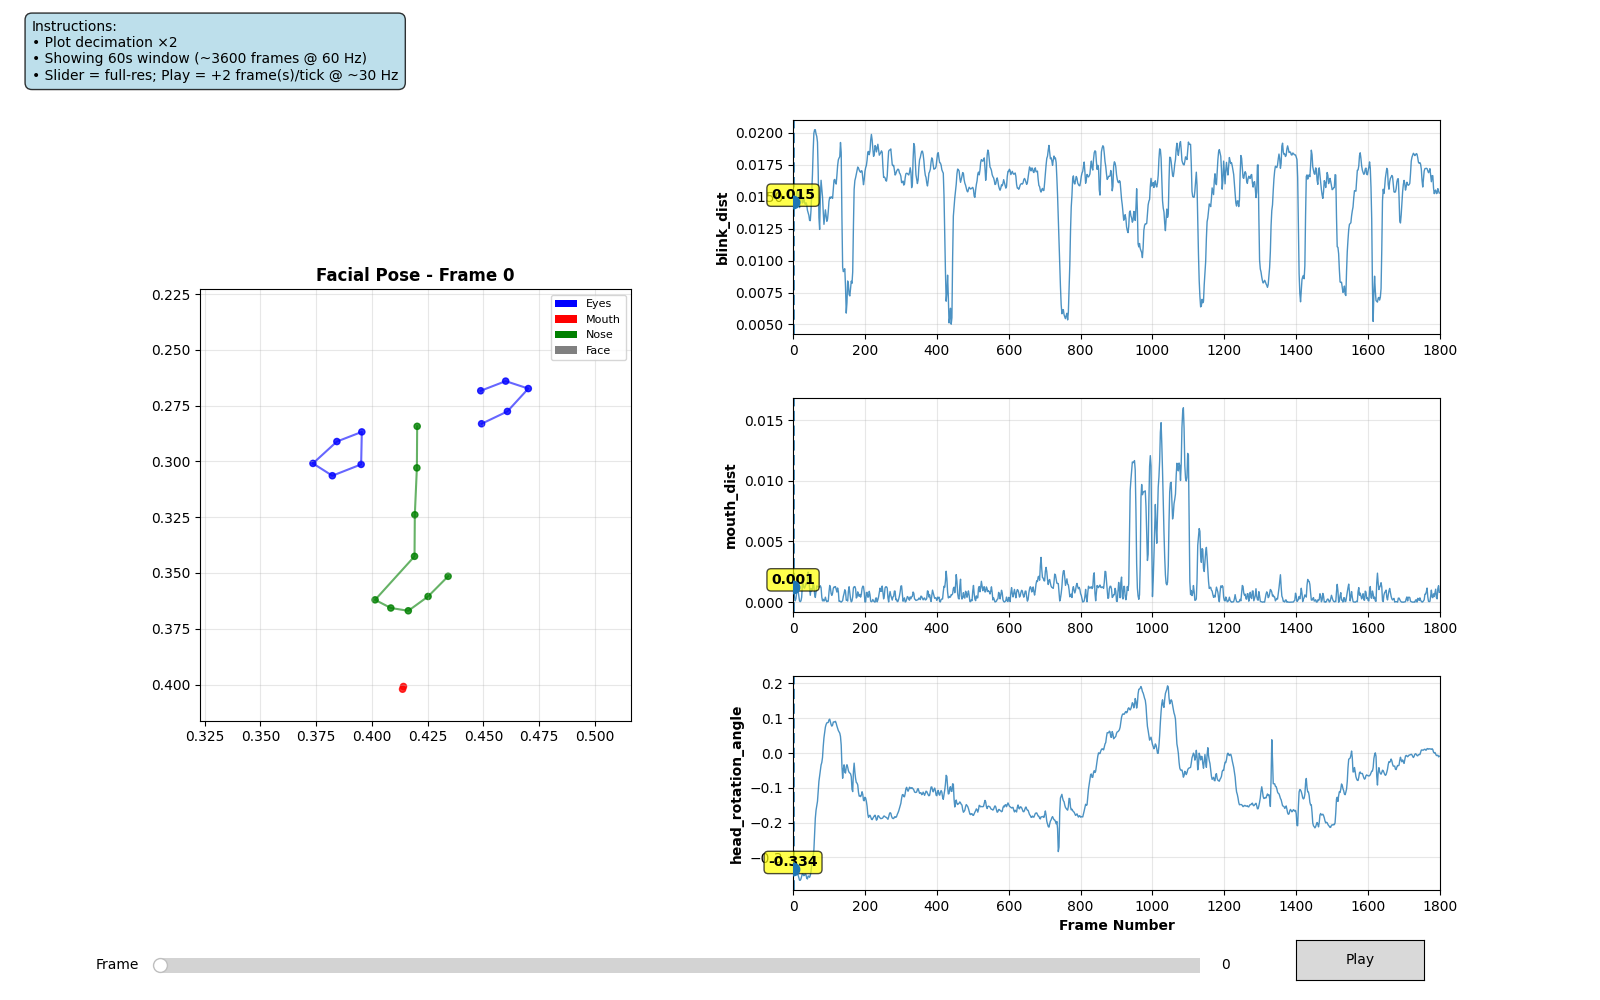

In [35]:
# %matplotlib widget
from pathlib import Path
import numpy as np
import pandas as pd
import math

# ---------------- config ----------------
OUT_BASE = "data/processed/experimental"
SAMPLE_NORM = None   # e.g., "data/processed/experimental/norm_screen/472_H_norm.csv"
FPS = 60
WINDOW_SECONDS = 60

# ------------- helpers (minimal) -------------
def _pick_norm_file():
    if SAMPLE_NORM:
        return Path(SAMPLE_NORM)
    norm_dir = Path(OUT_BASE) / "norm_screen"
    files = sorted(norm_dir.glob("*_norm.csv"))
    if not files:
        raise FileNotFoundError(f"No normalized CSVs in {norm_dir}. Run the pipeline first.")
    return files[0]

def _col(df, axis, i):
    c1, c2 = f"{axis}{i}", f"{axis.upper()}{i}"
    return c1 if c1 in df.columns else (c2 if c2 in df.columns else None)

def _series(df, axis, i, n):
    c = _col(df, axis, i)
    return pd.to_numeric(df[c], errors="coerce") if c else pd.Series([np.nan]*n)

def _slice_60s(df):
    n = len(df)
    end = min(n, FPS * WINDOW_SECONDS)
    return df.iloc[:end].reset_index(drop=True)

def _rel_indices():
    s = set()
    s.update((30,31,37,46))
    s.update((37,46))
    s.update((38,39,41,42,44,45,47,48))
    s.update((63,67))
    s.update(range(1,69))  # display everything if present
    return sorted(s)

def _angle(p1, p2):
    return math.atan2(float(p2[1]-p1[1]), float(p2[0]-p1[0]))

def _blink_ap(top2, bot2):
    top_mean = top2.mean(axis=0); bot_mean = bot2.mean(axis=0)
    return abs(float(top_mean[1] - bot_mean[1]))

def _mouth_ap(p63, p67):
    return float(np.linalg.norm(p67 - p63))

def _procrustes_frame_to_template(frame_xy, templ_xy, avail_mask):
    idx = np.where(avail_mask)[0]
    if idx.size < 3:
        return False, np.nan, np.nan, np.nan, np.full((2,2), np.nan), np.full_like(frame_xy, np.nan)
    X = frame_xy[idx,:]; Y = templ_xy[idx,:]
    muX = X.mean(axis=0, keepdims=True); muY = Y.mean(axis=0, keepdims=True)
    Xc = X - muX; Yc = Y - muY
    C = Xc.T @ Yc
    U,S,Vt = np.linalg.svd(C)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[1,:] *= -1
        R = Vt.T @ U.T
    varX = (Xc**2).sum()
    s = (S.sum()) / varX if varX > 0 else 1.0
    t = (muY.T - s * R @ muX.T).reshape(2)
    Xall = frame_xy.copy()
    Xtrans = (s * (R @ (Xall - muX).T)).T + muY
    return True, float(s), float(t[0]), float(t[1]), R, Xtrans

# ------------- load pose + template -------------
norm_path = _pick_norm_file()
df_norm_full = pd.read_csv(norm_path)
df_norm = _slice_60s(df_norm_full)

templ_path = Path(OUT_BASE) / "templates" / "global_template.csv"
if not templ_path.exists():
    raise FileNotFoundError(f"Missing global template at {templ_path}. Run templates step first.")
templ_df = pd.read_csv(templ_path)

# ------------- build Procrustes-aligned pose for 60s -------------
rel = _rel_indices()
# map columns
def _cols(df, axis):
    cols = {}
    for i in rel:
        c = _col(df, axis, i)
        if c: cols[i] = c
    return cols

xcols = _cols(df_norm, "x"); ycols = _cols(df_norm, "y")
templ_xy = np.column_stack([
    [templ_df.iloc[0][ _col(templ_df, "x", i) ] if _col(templ_df, "x", i) else np.nan for i in rel],
    [templ_df.iloc[0][ _col(templ_df, "y", i) ] if _col(templ_df, "y", i) else np.nan for i in rel],
])

n = len(df_norm)
# pre-allocate transformed pose as DataFrame with x1..y68
cols_out = []
for i in range(1,69):
    cols_out += [f"x{i}", f"y{i}"]
data_out = np.full((n, len(cols_out)), np.nan, float)

# features
head_rotation_angle = np.full(n, np.nan, float)
blink_dist = np.full(n, np.nan, float)
mouth_dist = np.full(n, np.nan, float)

def _idx(i): 
    try: return rel.index(i)
    except ValueError: return -1

Ltop = [_idx(38), _idx(39)]; Lbot = [_idx(41), _idx(42)]
Rtop = [_idx(44), _idx(45)]; Rbot = [_idx(47), _idx(48)]
eye_pair = (_idx(37), _idx(46))
mouth_pair = (_idx(63), _idx(67))

for t in range(n):
    fx = [pd.to_numeric(df_norm.iloc[t][xcols[i]], errors="coerce") if i in xcols else np.nan for i in rel]
    fy = [pd.to_numeric(df_norm.iloc[t][ycols[i]], errors="coerce") if i in ycols else np.nan for i in rel]
    frame_xy = np.column_stack([np.asarray(fx,float), np.asarray(fy,float)])
    avail = np.isfinite(frame_xy).all(axis=1) & np.isfinite(templ_xy).all(axis=1)
    ok, s, tx, ty, R, X = _procrustes_frame_to_template(frame_xy, templ_xy, avail)
    if not ok:
        continue

    # fill transformed pose into output table for this frame
    for i in range(1,69):
        if i in rel:
            j = rel.index(i)
            if np.isfinite(X[j]).all():
                data_out[t, 2*(i-1)  ] = X[j,0]
                data_out[t, 2*(i-1)+1] = X[j,1]

    # features on transformed pose
    i37, i46 = eye_pair
    if i37 >= 0 and i46 >= 0 and np.isfinite(X[i37]).all() and np.isfinite(X[i46]).all():
        head_rotation_angle[t] = _angle(X[i37], X[i46])

    def _safe_pts(idxs):
        pts = [X[k] for k in idxs if k >= 0 and np.isfinite(X[k]).all()]
        return np.vstack(pts) if len(pts) == 2 else None

    vals = []
    ltop, lbot = _safe_pts(Ltop), _safe_pts(Lbot)
    rtop, rbot = _safe_pts(Rtop), _safe_pts(Rbot)
    if ltop is not None and lbot is not None: vals.append(_blink_ap(ltop,lbot))
    if rtop is not None and rbot is not None: vals.append(_blink_ap(rtop,rbot))
    if vals: blink_dist[t] = float(np.mean(vals))

    m63, m67 = mouth_pair
    if m63 >= 0 and m67 >= 0 and np.isfinite(X[m63]).all() and np.isfinite(X[m67]).all():
        mouth_dist[t] = _mouth_ap(X[m63], X[m67])

# df for viewer
df_pose_procrustes_global = pd.DataFrame(data_out, columns=cols_out)
df_features_procrustes_global = pd.DataFrame({
    "head_rotation_angle": head_rotation_angle,
    "blink_dist": blink_dist,
    "mouth_dist": mouth_dist,
})

# ------------- launch interactive viewer -------------
fig_procrustes_global = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose_procrustes_global,
    df_features=df_features_procrustes_global,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=FPS,
    plot_downsample=2,
    window_seconds=60
)


## 3. Feature Extraction with Procrustes Analysis (Participant Template)

Extract features using participant-specific template alignment.

Displaying 68 landmarks


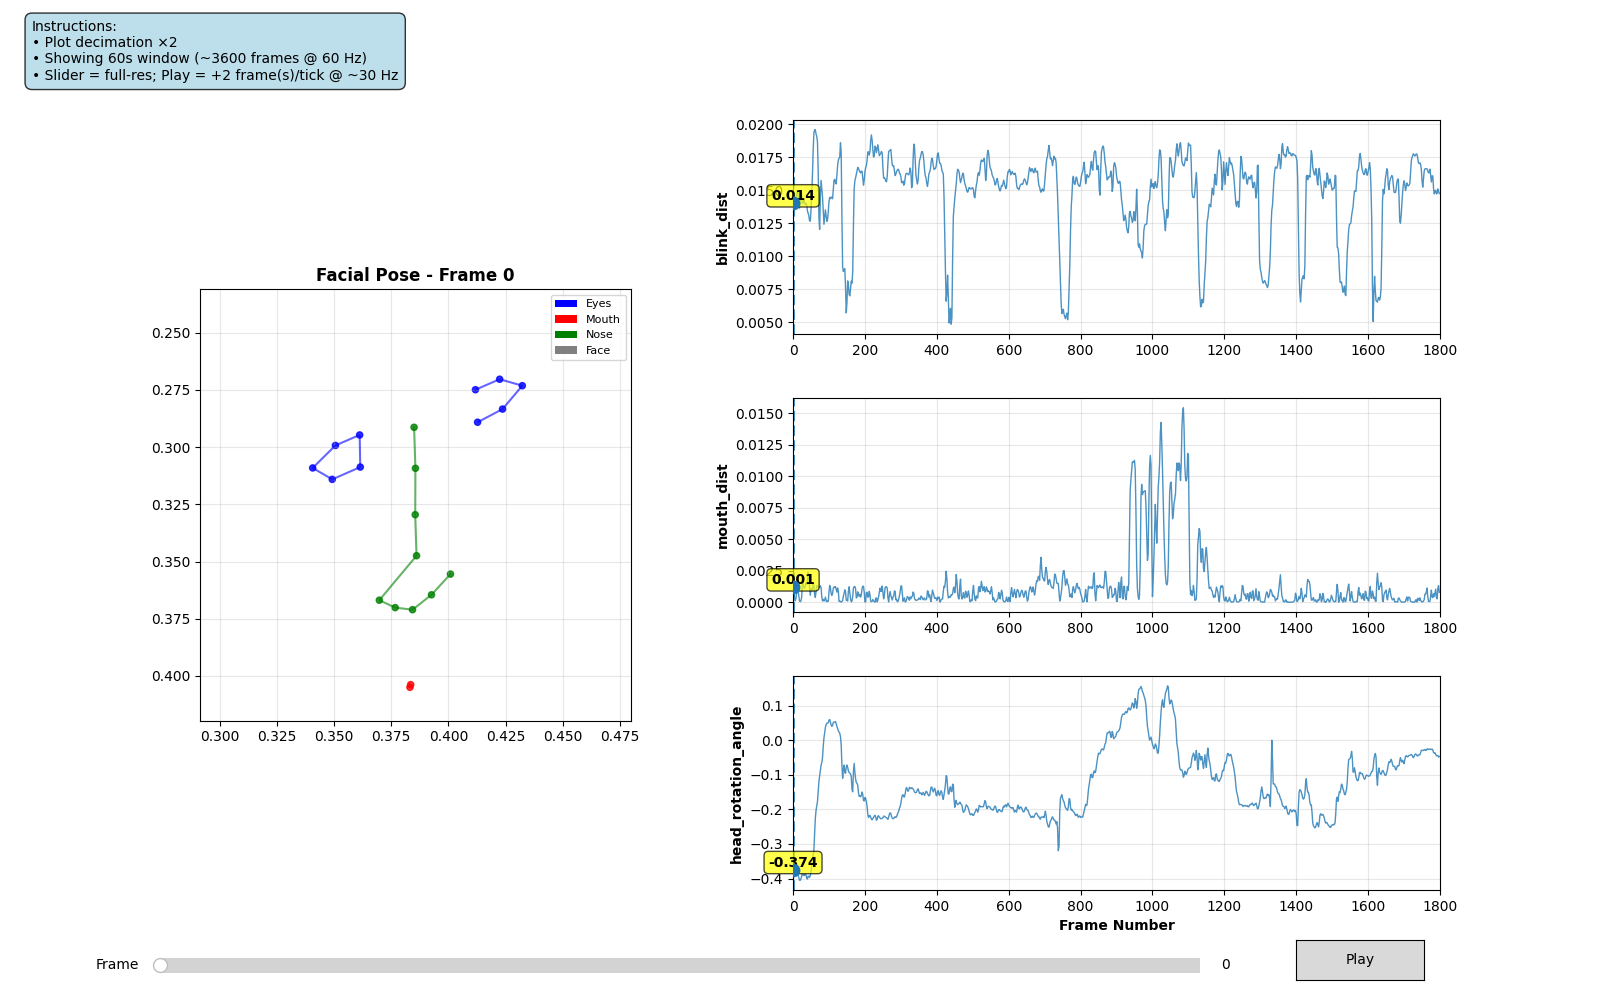

In [37]:
# %matplotlib widget
from pathlib import Path
import numpy as np
import pandas as pd
import re
import math

# ---------------- config ----------------
OUT_BASE = "data/processed/experimental"
SAMPLE_NORM = None   # e.g., "data/processed/experimental/norm_screen/472_H_norm.csv"
FPS = 60
WINDOW_SECONDS = 60

# ------------- helpers (minimal) -------------
def _pick_norm_file():
    if SAMPLE_NORM:
        return Path(SAMPLE_NORM)
    norm_dir = Path(OUT_BASE) / "norm_screen"
    files = sorted(norm_dir.glob("*_norm.csv"))
    if not files:
        raise FileNotFoundError(f"No normalized CSVs in {norm_dir}. Run the pipeline first.")
    return files[0]

def _parse_pid_cond(p):
    base = Path(p).name
    m = re.match(r"^([A-Za-z0-9]+)_([A-Za-z0-9]+)", Path(base).stem)
    return (m.group(1), m.group(2)) if m else ("NA","NA")

def _col(df, axis, i):
    c1, c2 = f"{axis}{i}", f"{axis.upper()}{i}"
    return c1 if c1 in df.columns else (c2 if c2 in df.columns else None)

def _series(df, axis, i, n):
    c = _col(df, axis, i)
    return pd.to_numeric(df[c], errors="coerce") if c else pd.Series([np.nan]*n)

def _slice_60s(df):
    n = len(df)
    end = min(n, FPS * WINDOW_SECONDS)
    return df.iloc[:end].reset_index(drop=True)

def _rel_indices():
    s = set()
    s.update((30,31,37,46))
    s.update((37,46))
    s.update((38,39,41,42,44,45,47,48))
    s.update((63,67))
    s.update(range(1,69))
    return sorted(s)

def _angle(p1, p2):
    return math.atan2(float(p2[1]-p1[1]), float(p2[0]-p1[0]))

def _blink_ap(top2, bot2):
    top_mean = top2.mean(axis=0); bot_mean = bot2.mean(axis=0)
    return abs(float(top_mean[1] - bot_mean[1]))

def _mouth_ap(p63, p67):
    return float(np.linalg.norm(p67 - p63))

def _procrustes_frame_to_template(frame_xy, templ_xy, avail_mask):
    idx = np.where(avail_mask)[0]
    if idx.size < 3:
        return False, np.nan, np.nan, np.nan, np.full((2,2), np.nan), np.full_like(frame_xy, np.nan)
    X = frame_xy[idx,:]; Y = templ_xy[idx,:]
    muX = X.mean(axis=0, keepdims=True); muY = Y.mean(axis=0, keepdims=True)
    Xc = X - muX; Yc = Y - muY
    C = Xc.T @ Yc
    U,S,Vt = np.linalg.svd(C)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[1,:] *= -1
        R = Vt.T @ U.T
    varX = (Xc**2).sum()
    s = (S.sum()) / varX if varX > 0 else 1.0
    t = (muY.T - s * R @ muX.T).reshape(2)
    Xall = frame_xy.copy()
    Xtrans = (s * (R @ (Xall - muX).T)).T + muY
    return True, float(s), float(t[0]), float(t[1]), R, Xtrans

# ------------- load pose + participant template -------------
norm_path = _pick_norm_file()
pid, cond = _parse_pid_cond(norm_path)
df_norm_full = pd.read_csv(norm_path)
df_norm = _slice_60s(df_norm_full)

part_templ_path = Path(OUT_BASE) / "templates" / f"participant_{pid}_template.csv"
if not part_templ_path.exists():
    raise FileNotFoundError(f"Missing participant template at {part_templ_path}. Run templates step first.")
templ_df = pd.read_csv(part_templ_path)

# ------------- build Procrustes-aligned pose for 60s -------------
rel = _rel_indices()
def _cols(df, axis):
    cols = {}
    for i in rel:
        c = _col(df, axis, i)
        if c: cols[i] = c
    return cols

xcols = _cols(df_norm, "x"); ycols = _cols(df_norm, "y")
templ_xy = np.column_stack([
    [templ_df.iloc[0][ _col(templ_df, "x", i) ] if _col(templ_df, "x", i) else np.nan for i in rel],
    [templ_df.iloc[0][ _col(templ_df, "y", i) ] if _col(templ_df, "y", i) else np.nan for i in rel],
])

n = len(df_norm)
cols_out = []
for i in range(1,69):
    cols_out += [f"x{i}", f"y{i}"]
data_out = np.full((n, len(cols_out)), np.nan, float)

head_rotation_angle = np.full(n, np.nan, float)
blink_dist = np.full(n, np.nan, float)
mouth_dist = np.full(n, np.nan, float)

def _idx(i): 
    try: return rel.index(i)
    except ValueError: return -1

Ltop = [_idx(38), _idx(39)]; Lbot = [_idx(41), _idx(42)]
Rtop = [_idx(44), _idx(45)]; Rbot = [_idx(47), _idx(48)]
eye_pair = (_idx(37), _idx(46))
mouth_pair = (_idx(63), _idx(67))

for t in range(n):
    fx = [pd.to_numeric(df_norm.iloc[t][xcols[i]], errors="coerce") if i in xcols else np.nan for i in rel]
    fy = [pd.to_numeric(df_norm.iloc[t][ycols[i]], errors="coerce") if i in ycols else np.nan for i in rel]
    frame_xy = np.column_stack([np.asarray(fx,float), np.asarray(fy,float)])
    avail = np.isfinite(frame_xy).all(axis=1) & np.isfinite(templ_xy).all(axis=1)
    ok, s, tx, ty, R, X = _procrustes_frame_to_template(frame_xy, templ_xy, avail)
    if not ok:
        continue

    for i in range(1,69):
        if i in rel:
            j = rel.index(i)
            if np.isfinite(X[j]).all():
                data_out[t, 2*(i-1)  ] = X[j,0]
                data_out[t, 2*(i-1)+1] = X[j,1]

    i37, i46 = eye_pair
    if i37 >= 0 and i46 >= 0 and np.isfinite(X[i37]).all() and np.isfinite(X[i46]).all():
        head_rotation_angle[t] = _angle(X[i37], X[i46])

    def _safe_pts(idxs):
        pts = [X[k] for k in idxs if k >= 0 and np.isfinite(X[k]).all()]
        return np.vstack(pts) if len(pts) == 2 else None

    vals = []
    ltop, lbot = _safe_pts(Ltop), _safe_pts(Lbot)
    rtop, rbot = _safe_pts(Rtop), _safe_pts(Rbot)
    if ltop is not None and lbot is not None: vals.append(_blink_ap(ltop,lbot))
    if rtop is not None and rbot is not None: vals.append(_blink_ap(rtop,rbot))
    if vals: blink_dist[t] = float(np.mean(vals))

    m63, m67 = mouth_pair
    if m63 >= 0 and m67 >= 0 and np.isfinite(X[m63]).all() and np.isfinite(X[m67]).all():
        mouth_dist[t] = _mouth_ap(X[m63], X[m67])

df_pose_procrustes_participant = pd.DataFrame(data_out, columns=cols_out)
df_features_procrustes_participant = pd.DataFrame({
    "head_rotation_angle": head_rotation_angle,
    "blink_dist": blink_dist,
    "mouth_dist": mouth_dist,
})

# ------------- launch interactive viewer -------------
fig_procrustes_participant = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose_procrustes_participant,
    df_features=df_features_procrustes_participant,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=FPS,
    plot_downsample=2,
    window_seconds=60
)


## 4. Original Method Features (No Procrustes Alignment)

Extract features from raw normalized coordinates without alignment.

Displaying 21 landmarks


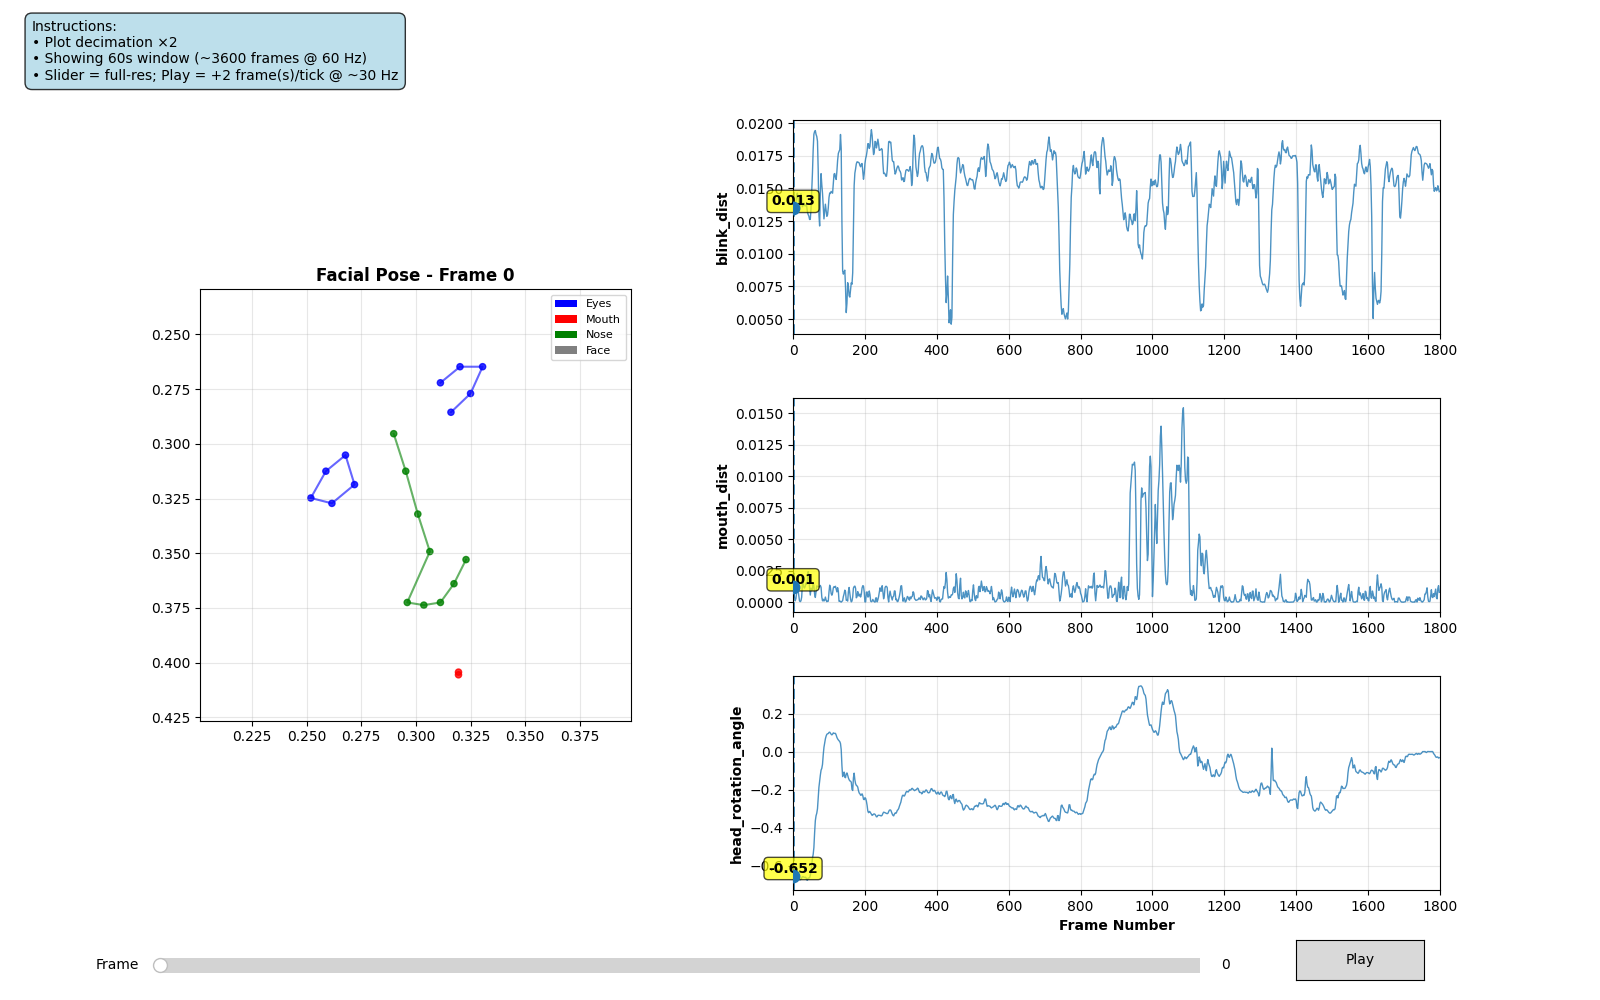

In [34]:
# %matplotlib widget  # (already enabled earlier in your notebook)
from pathlib import Path
import numpy as np
import pandas as pd
import re

# ---------------- config ----------------
OUT_BASE = "data/processed/experimental"
SAMPLE_NORM = None   # e.g., "data/processed/experimental/norm_screen/472_H_norm.csv"
FPS = 60
WINDOW_SECONDS = 60

# ------------- helpers (minimal) -------------
def _pick_norm_file():
    if SAMPLE_NORM:
        return Path(SAMPLE_NORM)
    norm_dir = Path(OUT_BASE) / "norm_screen"
    files = sorted(norm_dir.glob("*_norm.csv"))
    if not files:
        raise FileNotFoundError(f"No normalized CSVs in {norm_dir}. Run the pipeline first.")
    return files[0]

def _col(df, axis, i):
    c1, c2 = f"{axis}{i}", f"{axis.upper()}{i}"
    return c1 if c1 in df.columns else (c2 if c2 in df.columns else None)

def _series(df, axis, i, n):
    c = _col(df, axis, i)
    return pd.to_numeric(df[c], errors="coerce") if c else pd.Series([np.nan]*n)

def _slice_60s(df):
    n = len(df)
    end = min(n, FPS * WINDOW_SECONDS)
    return df.iloc[:end].reset_index(drop=True)

# ------------- load & slice -------------
norm_path = _pick_norm_file()
df_norm_full = pd.read_csv(norm_path)
df_pose = _slice_60s(df_norm_full)  # this is the "Original" pose

# ------------- features (Original coords) -------------
n = len(df_pose)

# head rotation (radians) from eye corners 37→46
x37 = _series(df_pose, "x", 37, n); y37 = _series(df_pose, "y", 37, n)
x46 = _series(df_pose, "x", 46, n); y46 = _series(df_pose, "y", 46, n)
dx = (x46 - x37).to_numpy(float); dy = (y46 - y37).to_numpy(float)
head_rotation_angle = np.arctan2(dy, dx)

# blink distance: average vertical lid distance L/R
def _avg2(a,b): return (a+b)/2.0
Ltop = _avg2(_series(df_pose,"y",38,n), _series(df_pose,"y",39,n))
Lbot = _avg2(_series(df_pose,"y",41,n), _series(df_pose,"y",42,n))
Rtop = _avg2(_series(df_pose,"y",44,n), _series(df_pose,"y",45,n))
Rbot = _avg2(_series(df_pose,"y",47,n), _series(df_pose,"y",48,n))
blink_L = (Ltop - Lbot).abs().to_numpy(float)
blink_R = (Rtop - Rbot).abs().to_numpy(float)
blink_dist = np.where(np.isfinite(blink_L) & np.isfinite(blink_R),
                      (blink_L + blink_R)/2.0,
                      np.where(np.isfinite(blink_L), blink_L,
                               np.where(np.isfinite(blink_R), blink_R, np.nan)))

# mouth distance: ||(63)-(67)||
x63 = _series(df_pose,"x",63,n).to_numpy(float); y63 = _series(df_pose,"y",63,n).to_numpy(float)
x67 = _series(df_pose,"x",67,n).to_numpy(float); y67 = _series(df_pose,"y",67,n).to_numpy(float)
mouth_dist = np.sqrt((x67-x63)**2 + (y67-y63)**2)

df_features = pd.DataFrame({
    "head_rotation_angle": head_rotation_angle,
    "blink_dist": blink_dist,
    "mouth_dist": mouth_dist,
})

# ------------- launch interactive viewer -------------
# Assumes create_interactive_pose_timeseries_viewer() is already defined (from your previous cell).
fig_original = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose,
    df_features=df_features,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=FPS,
    plot_downsample=2,
    window_seconds=60
)


## 5. Linear Metrics Analysis

Analyze velocity, acceleration, and RMS variability with statistical comparisons.

In [ ]:
# %pip install -q ipywidgets scipy
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from ipywidgets import ToggleButtons, Dropdown, Checkbox, VBox, HBox, Output
from IPython.display import display
from scipy import stats

# ---------------- paths & constants ----------------
LIN_BASE = "data/processed/experimental/linear_metrics"
CSV_MAP = {
    "Original":                   os.path.join(LIN_BASE, "original_linear.csv"),
    "Procrustes (Global)":        os.path.join(LIN_BASE, "procrustes_global_linear.csv"),
    "Procrustes (Participant)":   os.path.join(LIN_BASE, "procrustes_participant_linear.csv"),
}
COND_ORDER = ["L", "M", "H"]
COND_COLORS = {"L": "#1f77b4", "M": "#f1c40f", "H": "#8B0000"}  # blue, yellow, dark red
META_COLS = {"source","participant","condition","window_index","t_start_frame","t_end_frame"}

# ---------------- helpers ----------------
def ensure_condition_order(df: pd.DataFrame) -> pd.DataFrame:
    if "condition" in df.columns:
        df["condition"] = pd.Categorical(df["condition"], categories=COND_ORDER, ordered=True)
    return df

def sem(series):
    s = pd.Series(series).astype(float)
    return s.std(ddof=1) / np.sqrt(s.count())

def load_linear_df(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing file: {csv_path}")
    df = pd.read_csv(csv_path)
    return ensure_condition_order(df)

def candidate_metric_cols(df: pd.DataFrame):
    # numeric columns that are not obvious meta columns
    num_cols = [c for c in df.columns if c not in META_COLS and pd.api.types.is_numeric_dtype(df[c])]
    priority, others = [], []
    for c in num_cols:
        lc = c.lower()
        if lc.endswith("_mean_abs_vel") or lc.endswith("_mean_abs_acc") or lc.endswith("_rms"):
            priority.append(c)
        else:
            others.append(c)
    return priority + others

def default_metric(cols):
    lowers = [c.lower() for c in cols]
    # prefer blink/mouth/center_face *_rms first, then any *_rms
    for exact in [
        "blink_aperture_rms", "mouth_aperture_rms", "center_face_magnitude_rms",
        "blink_aperture_mean_abs_vel", "mouth_aperture_mean_abs_vel",
    ]:
        if exact in lowers:
            return cols[lowers.index(exact)]
    for i, lc in enumerate(lowers):
        if lc.endswith("_rms"):
            return cols[i]
    return cols[0] if cols else None

def bar_by_condition(df: pd.DataFrame, metric: str, title_suffix: str = ""):
    grouped = df.groupby("condition")[metric].agg(["mean", sem]).reindex(COND_ORDER)
    idx = np.arange(len(COND_ORDER))
    means = grouped["mean"].to_numpy(dtype=float)
    errs  = grouped["sem"].to_numpy(dtype=float)
    colors = [COND_COLORS[c] for c in COND_ORDER]

    fig, ax = plt.subplots(figsize=(6.2, 4.2))
    ax.bar(idx, means, yerr=errs, capsize=4, width=0.75, color=colors, edgecolor="black", alpha=0.9)
    ax.set_xticks(idx); ax.set_xticklabels(COND_ORDER)
    ax.set_xlabel("Condition"); ax.set_ylabel("Mean ± SEM")
    ttl = f"{metric} by Condition"
    if title_suffix: ttl += f" — {title_suffix}"
    ax.set_title(ttl)
    ax.set_xlim(-0.5, len(COND_ORDER)-0.5)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
    ax.grid(axis="y", alpha=0.25)
    for x, m in zip(idx, means):
        if np.isfinite(m):
            ax.text(x, m, f"{m:.3f}", ha="center", va="bottom", fontsize=9, fontweight="bold")
    plt.tight_layout()
    plt.show()

def holm_bonferroni(pvals: dict):
    """Return dict of corrected p-values using Holm–Bonferroni."""
    # pvals: {label: p}
    items = sorted(pvals.items(), key=lambda kv: kv[1])  # ascending by p
    m = len(items)
    corrected = {}
    for i, (lbl, p) in enumerate(items, start=1):
        corrected[lbl] = min(p * (m - i + 1), 1.0)
    # restore original order
    return {k: corrected[k] for k in pvals.keys()}

def compare_groups_statistical(df: pd.DataFrame, metric: str, test_type: str = "auto"):
    """Omnibus across L/M/H, then Holm–Bonferroni pairwise."""
    # collect groups (drop NaN metric)
    work = df[["condition", metric]].dropna()
    groups = [work[work["condition"] == c][metric].astype(float).values for c in COND_ORDER if (work["condition"] == c).any()]
    group_names = [c for c in COND_ORDER if (work["condition"] == c).any()]
    k = len(groups)

    # descriptives
    desc = []
    for c in group_names:
        vals = work.loc[work["condition"] == c, metric].astype(float)
        desc.append({
            "condition": c, "n": int(vals.count()),
            "mean": float(vals.mean()), "std": float(vals.std(ddof=1)),
            "sem": float(vals.sem()), "median": float(vals.median())
        })
    desc_df = pd.DataFrame(desc).set_index("condition").reindex(COND_ORDER)

    # choose test
    if test_type == "auto":
        # Shapiro per group if n>=3
        normal = True
        for vals in groups:
            if len(vals) >= 3:
                try:
                    _, p = stats.shapiro(vals)
                except Exception:
                    p = 1.0
                if p < 0.05:
                    normal = False
                    break
        test_type = "parametric" if normal else "nonparametric"

    # omnibus
    omni_name = None; omni_stat = np.nan; omni_p = np.nan
    if k >= 2:
        if test_type == "parametric":
            omni_name = "One-way ANOVA" if k > 2 else "Independent t-test"
            if k > 2:
                omni_stat, omni_p = stats.f_oneway(*groups)
            else:
                omni_stat, omni_p = stats.ttest_ind(*groups, equal_var=False)
        else:
            omni_name = "Kruskal–Wallis" if k > 2 else "Mann–Whitney U"
            if k > 2:
                omni_stat, omni_p = stats.kruskal(*groups)
            else:
                omni_stat, omni_p = stats.mannwhitneyu(*groups)

    # pairwise with Holm–Bonferroni (only if k>2 and omnibus sig, or always if you prefer)
    pairs = {}
    raw_p = {}
    if k > 2:
        for i in range(k):
            for j in range(i+1, k):
                a, b = groups[i], groups[j]
                label = f"{group_names[i]} vs {group_names[j]}"
                if test_type == "parametric":
                    _, p = stats.ttest_ind(a, b, equal_var=False)
                else:
                    _, p = stats.mannwhitneyu(a, b, alternative="two-sided")
                raw_p[label] = float(p)
        corr = holm_bonferroni(raw_p) if raw_p else {}
        for label in raw_p:
            pairs[label] = {"p_raw": raw_p[label], "p_holm": corr[label], "significant_0.05": corr[label] < 0.05}

    return {
        "metric": metric,
        "test_type": test_type,
        "omnibus": {"name": omni_name, "stat": float(omni_stat), "p": float(omni_p)},
        "descriptives": desc_df,
        "pairwise": pd.DataFrame.from_dict(pairs, orient="index") if pairs else pd.DataFrame()
    }

# ---------------- widgets ----------------
w_norm = ToggleButtons(
    options=list(CSV_MAP.keys()),
    value="Original",
    description="Normalization:",
)
w_metric = Dropdown(options=[], description="Metric:")
w_test = ToggleButtons(options=["auto", "parametric", "nonparametric"], value="auto", description="Test:")
out_plot = Output()
out_stats = Output()

def refresh_metric_options(norm_label):
    df = load_linear_df(CSV_MAP[norm_label])
    cols = candidate_metric_cols(df)
    if not cols:
        w_metric.options = []; w_metric.value = None
    else:
        w_metric.options = cols
        if w_metric.value in cols:
            pass
        else:
            w_metric.value = default_metric(cols)

def draw_everything(*_):
    out_plot.clear_output(); out_stats.clear_output()
    try:
        norm_label = w_norm.value
        df = load_linear_df(CSV_MAP[norm_label])
        if not w_metric.options or w_metric.value not in w_metric.options:
            refresh_metric_options(norm_label)
        metric = w_metric.value
        if metric is None:
            with out_plot: print("No numeric metric found in file.")
            return

        # plot
        with out_plot:
            bar_by_condition(df, metric, title_suffix=norm_label)

        # stats
        res = compare_groups_statistical(df, metric, test_type=w_test.value)
        with out_stats:
            print(f"Omnibus: {res['omnibus']['name']}  stat={res['omnibus']['stat']:.4f}  p={res['omnibus']['p']:.4g}")
            print(f"Test type chosen: {res['test_type']}\n")
            print("Descriptives (per condition):")
            display(res["descriptives"].style.format({"mean":"{:.4f}","std":"{:.4f}","sem":"{:.4f}","median":"{:.4f}"}))
            if not res["pairwise"].empty:
                print("\nPairwise (Holm–Bonferroni corrected):")
                display(res["pairwise"].style.format({"p_raw":"{:.4g}","p_holm":"{:.4g}"}))
            else:
                print("\nPairwise: (k<=2 or not applicable)")
    except Exception as e:
        with out_stats:
            print(f"[Error] {e}")

def on_norm_change(change):
    if change["name"] == "value":
        refresh_metric_options(change["new"])
        draw_everything()

def on_metric_change(change):
    if change["name"] == "value":
        draw_everything()

def on_test_change(change):
    if change["name"] == "value":
        draw_everything()

w_norm.observe(on_norm_change)
w_metric.observe(on_metric_change)
w_test.observe(on_test_change)

# init
refresh_metric_options(w_norm.value)
draw_everything()

display(VBox([HBox([w_norm, w_metric, w_test]), out_plot, out_stats]))
